# 数据处理

[![下载Notebook](https://gitee.com/mindspore/docs/raw/master/resource/_static/logo_notebook.png)](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/master/tutorials/zh_cn/mindspore_dataset.ipynb)&emsp;[![下载样例代码](https://gitee.com/mindspore/docs/raw/master/resource/_static/logo_download_code.png)](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/master/tutorials/zh_cn/mindspore_dataset.py)&emsp;[![查看源文件](https://gitee.com/mindspore/docs/raw/master/resource/_static/logo_source.png)](https://gitee.com/mindspore/docs/blob/master/tutorials/source_zh_cn/beginner/dataset.ipynb)

数据是深度学习的基础，高质量数据输入会在整个深度神经网络中起到积极作用。

[mindspore.dataset](https://www.mindspore.cn/docs/api/zh-CN/master/api_python/mindspore.dataset.html)提供了部分常用数据集和标准格式数据集的加载接口，使得用户能够快速进行数据处理操作。对于图像数据集，用户可使用`mindvision.dataset`来加载和处理数据集。本章首先介绍如何使用`mindvision.dataset.Cifar10`接口加载并处理CIFAR-10数据集，然后介绍如何使用`mindspore.dataset.GeneratorDataset`实现自定义数据集加载。

> `mindvision.dataset`是在`mindspore.dataset`的基础上开发的数据集接口。除提供数据集加载功能外，还提供数据集下载功能、数据处理和数据增强功能。

## 数据流程

在网络训练和推理流程中，原始数据一般存储在磁盘或数据库中，需要首先通过数据加载步骤将其读取到内存空间，转换成框架通用的张量（Tensor）格式，然后通过数据处理和增强步骤，将其映射到更加易于学习的特征空间，同时增加样本的数量和泛化性，最后输入到网络进行计算。

整体流程如下图所示：

![dataset-pipeline](https://gitee.com/mindspore/docs/raw/master/tutorials/source_zh_cn/beginner/images/dataset_pipeline.png)

### 数据集

数据集为一组样本的集合，数据集的一行即为一个样本包含一个或多个特征，此外还可能包含一个标签。数据集都需要符合一定规范要求，便于评估模型的效果。

Dataset支持多种格式数据集，包括MindSpore自研数据格式MindRecord，常用的公开图像数据集和文本数据集，用户自定义的数据集等。

### 数据集加载

数据集加载使得模型训练时能源源不断地获取数据进行训练。Dataset对多种常用的数据集提供对应的类来实现数据集的加载，同时对于不同存储格式的数据文件，Dataset也有对应的类来进行数据加载。

Dataset提供了多种用途的采样器（Sampler），采样器负责生成读取的index序列，Dataset负责根据index读取相应数据，帮助用户对数据集进行不同形式的采样，以满足训练需求，解决诸如数据集过大或样本类别分布不均等问题。

> 注意，采样器负责对样本做filter和reorder操作，不会执行Batch操作。

### 数据处理

Dataset将数据加载到内存后，数据按Tensor形式进行组织。同时Tensor也是数据增强操作中的基本数据结构。

## 加载数据集

下面的样例通过`mindvision.dataset.Cifar10`接口加载CIFAR-10数据集，CIFAR-10数据集共有60000张32*32的彩色图像，分为10个类别，每类有6000张图，数据集中一共有50000张训练图片和10000张测试图片。`Cifar10`接口提供CIFAR-10数据集下载及加载功能。

![cifar10](https://gitee.com/mindspore/docs/raw/master/tutorials/source_zh_cn/beginner/images/cifar10.jpg)

+ `path`：数据集根目录位置。
+ `split`：训练、测试或推理数据集，可选`train`，`test`或 `infer`，默认为`train`。
+ `download`：是否下载数据集，设置`True`时，若数据集不存在可下载并解压数据集，默认为`False`。


In [2]:
from mindvision.dataset import Cifar10

# 数据集根目录
data_dir = "./datasets"

# 下载解压并加载CIFAR-10训练数据集
dataset = Cifar10(path=data_dir, split='train', batch_size=6, resize=32, download=True)
dataset = dataset.run()

CIFAR-10数据集文件的目录结构如下：

```text
datasets/
├── cifar-10-batches-py
│   ├── batches.meta
│   ├── data_batch_1
│   ├── data_batch_2
│   ├── data_batch_3
│   ├── data_batch_4
│   ├── data_batch_5
│   ├── readme.html
│   └── test_batch
└── cifar-10-python.tar.gz
```

## 迭代数据集

用户可以用`create_dict_iterator`接口创建数据迭代器，迭代访问数据。访问的数据类型默认为`Tensor`；若设置`output_numpy=True`，访问的数据类型为`Numpy`。

下面展示了对应访问的数据类型、图片的形状和标签。

In [3]:
data = next(dataset.create_dict_iterator())
print(f"Data type:{type(data['image'])}\nImage shape: {data['image'].shape}, Label: {data['label']}")

data = next(dataset.create_dict_iterator(output_numpy=True))
print(f"Data type:{type(data['image'])}\nImage shape: {data['image'].shape}, Label: {data['label']}")

Data type:<class 'mindspore.common.tensor.Tensor'>
Image shape: (6, 3, 32, 32), Label: [7 1 2 8 7 8]
Data type:<class 'numpy.ndarray'>
Image shape: (6, 3, 32, 32), Label: [8 0 0 2 6 1]


## 数据处理及增强

### 数据处理

`mindvision.dataset.Cifar10`接口提供数据处理功能，只要设置相应的属性即可对数据进行处理操作。

+ `shuffle`：是否打乱数据集的顺序，设置为`True`时打乱数据集的顺序，默认为`False`。

+ `batch_size`：每组包含的数据个数，`batch_size=2`设置每组包含2个数据， `batch_size`值默认大小为32。

+ `repeat_num`：重复数据集的个数，`repeat_num=1`即一份数据集，`repeat_num`值默认为1 。

Image shape: (6, 3, 32, 32), Label: [9 3 8 9 6 8]


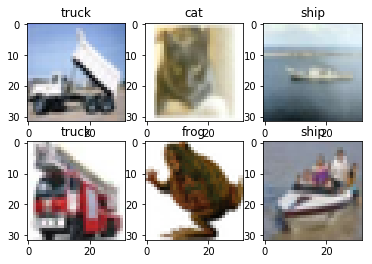

In [5]:
import numpy as np
import matplotlib.pyplot as plt

import mindspore.dataset.vision.c_transforms as transforms

trans = [transforms.HWC2CHW()]
dataset = Cifar10(data_dir, batch_size=6, resize=32, repeat_num=1, shuffle=True, transform=trans)
data = dataset.run()
data = next(data.create_dict_iterator())

images = data["image"].asnumpy()
labels = data["label"].asnumpy()
print(f"Image shape: {images.shape}, Label: {labels}")

plt.figure()
for i in range(1, 7):
    plt.subplot(2, 3, i)
    image_trans = np.transpose(images[i-1], (1, 2, 0))
    plt.title(f"{dataset.index2label[labels[i-1]]}")
    plt.imshow(image_trans, interpolation="None")
plt.show()

### 数据增强

数据量过小或是样本场景单一等问题会影响模型的训练效果，用户可以通过数据增强操作扩充样本多样性，从而提升模型的泛化能力。
`mindvision.dataset.Cifar10`接口使用默认的数据增强功能，用户可通过设置属性`transform`和`target_transform`进行数据增强操作。

+ `transform`：对数据集图像数据进行增强。
+ `target_transform`：对数据集标签数据进行处理。

本节介绍使用`mindspore.dataset.vision.c_transforms`模块中的算子对CIFAR-10数据集进行数据增强。

Image shape: (6, 3, 32, 32), Label: [7 6 7 4 5 3]


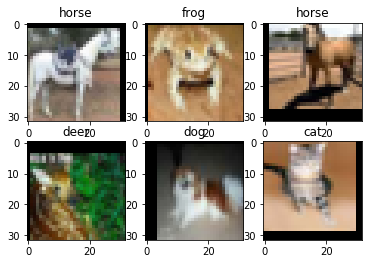

In [6]:
import numpy as np
import matplotlib.pyplot as plt

import mindspore.dataset.vision.c_transforms as transforms

# 图像增强
trans = [
    transforms.RandomCrop((32, 32), (4, 4, 4, 4)), # 对图像进行自动裁剪
    transforms.RandomHorizontalFlip(prob=0.5), # 对图像进行随机水平翻转
    transforms.HWC2CHW(), # (h, w, c)转换为(c, h, w)
]

dataset = Cifar10(data_dir, batch_size=6, resize=32, transform=trans)
data = dataset.run()
data = next(data.create_dict_iterator())
images = data["image"].asnumpy()
labels = data["label"].asnumpy()
print(f"Image shape: {images.shape}, Label: {labels}")

plt.figure()
for i in range(1, 7):
    plt.subplot(2, 3, i)
    image_trans = np.transpose(images[i-1], (1, 2, 0))
    plt.title(f"{dataset.index2label[labels[i-1]]}")
    plt.imshow(image_trans, interpolation="None")
plt.show()